In [1]:
import sys

sys.path.append("../src")

In [2]:
from medgc_tesis.pipelines.modeling.backbone import LeNetBackbone, ResNet18Backbone
from medgc_tesis.pipelines.modeling.models.data import DomainAdaptationDataModule
from torch import nn
from tqdm import tqdm
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

Global seed set to 48721


In [3]:
import os

os.chdir("..")

In [4]:
%load_ext kedro.extras.extensions.ipython

2023-07-09 19:07:13,568 - root - INFO - Updated path to Kedro project: /Users/francolianza/code/medgc-tesis
2023-07-09 19:07:13,827 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/Users/francolianza/miniforge3/envs/domain-adaptation/lib/python3.9/site-packages/kedro/framework/context/context.py:333: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/Users/francolianza/code/medgc-tesis/conf/base', '/Users/francolianza/code/medgc-tesis/conf/local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


2023-07-09 19:07:14,471 - root - INFO - ** Kedro project MEDGC Tesis
2023-07-09 19:07:14,472 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [5]:
def embedding_plot(X_s, X_t, s_X, figsize=(7, 7)):
    x_min, x_max = np.min(X_s, axis=0), np.max(X_s, axis=0)
    X_s = (X_s - x_min) / (x_max - x_min)
    X_t = (X_t - x_min) / (x_max - x_min)

    idx = np.arange(X_s.shape[0]) 
    np.random.shuffle(idx)
    idx = idx[:800]

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(X_s[idx, 0], X_s[idx, 1], alpha=0.6, s=2, label="MNIST")
    ax.scatter(X_t[idx, 0], X_t[idx, 1], alpha=0.6, s=2, label="TDS")

    # shown_images = np.array([[1.0, 1.0]])
    # offset = 0.05
    # for i in range(X_s.shape[0]):
    #     if np.min(np.sum((X_s[i] - shown_images) ** 2, axis=1)) < 5e-2:
    #         continue
    #     shown_images = np.r_[shown_images, [X_s[i]]]
    #     ax.add_artist(offsetbox.AnnotationBbox(offsetbox.OffsetImage(s_X[i][0, :, :], cmap=plt.cm.gray_r, zoom=0.4), (X_s[i][0] + offset, X_s[i][1] - offset)))
    offset = 0.05
    plt.axis('off')
    plt.xlim(X_s.min(), X_s.max() + offset * 2)
    plt.xlim(X_s.min(), X_s.max() + offset * 2)

In [6]:
das = ["source_only"]
modelos = ["resnet", "lenet"]
nombres = {
    'afn': "AFN",
    'source_only': "Solo Origen",
    'dann': "DANN",
    'adda': "ADDA",
    'bsp': "DANN+BSP",
    'mdd': "MDD",
    'resnet': "ResNet18",
    'lenet': "LeNet",
}

2023-07-09 19:07:14,490 - kedro.io.data_catalog - INFO - Loading data from `modelo_resnet_source_only` (PytorchModelDataSet)...
Calculando features


16it [00:08,  1.91it/s]                      


Aplicando UMAP
Graficando


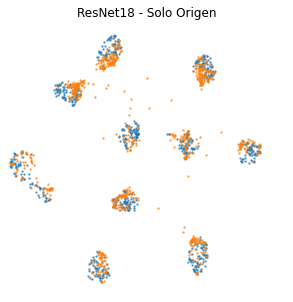

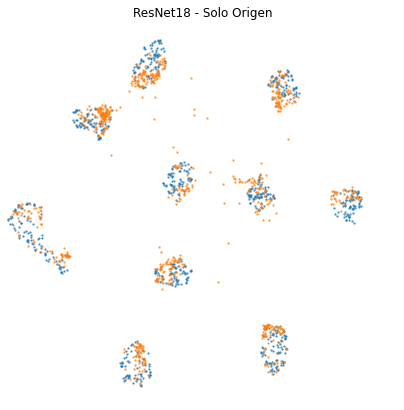

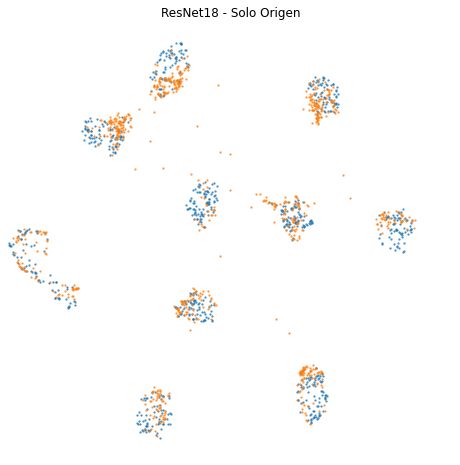

2023-07-09 19:07:50,366 - kedro.io.data_catalog - INFO - Loading data from `modelo_lenet_source_only` (PytorchModelDataSet)...


Global seed set to 48721


Calculando features


16it [00:05,  3.00it/s]                      


Aplicando UMAP
Graficando


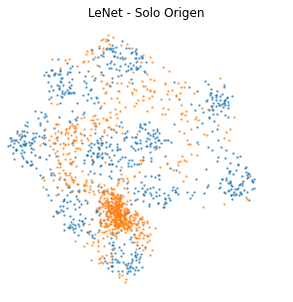

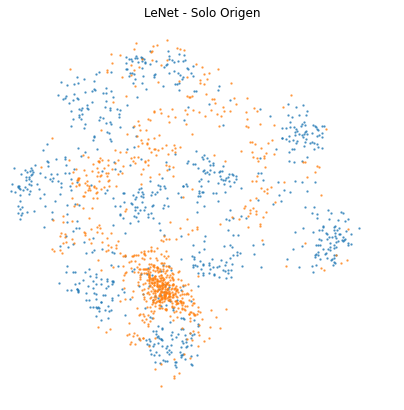

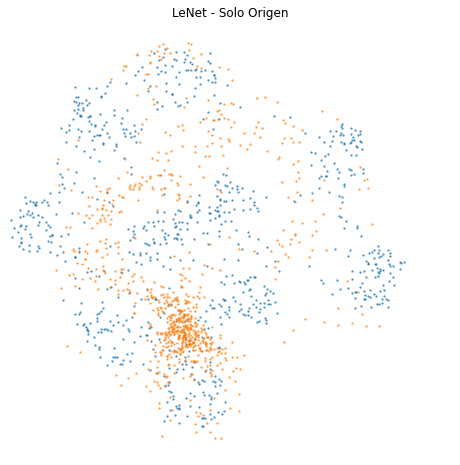

In [7]:
for da in das:
    for modelo in modelos:
        model = catalog.load(f"modelo_{modelo}_{da}")
        backbone = ResNet18Backbone() if modelo == 'resnet' else LeNetBackbone()

        if hasattr(model, "pool_layer"):
            feature_extractor = nn.Sequential(model.backbone, model.pool_layer, model.bottleneck)
        else:
            feature_extractor = nn.Sequential(model.backbone, model.bottleneck)

        feature_extractor = feature_extractor.to("mps")

        dm = DomainAdaptationDataModule(transform=backbone.data_transform())
        dm.setup(None)
        dataloader = dm.test_dataloader()
        del dm

        x_ss = []
        f_ss = []
        f_tt = []

        print("Calculando features")
        for idx, batch in enumerate(tqdm(dataloader)):
            if idx > 15:
                break

            x_s, _ = batch["mnist"]
            x_t, _ = batch["tds"]
            
            x_s = x_s.to("mps")
            x_t = x_t.to("mps")

            f_s = feature_extractor(x_s)
            f_t = feature_extractor(x_t)

            x_ss.append(x_s.cpu().detach())
            f_ss.append(f_s.cpu().detach())
            f_tt.append(f_t.cpu().detach())
        
        s_x = torch.cat(x_ss, dim=0).cpu().detach().numpy()
        s_features = torch.cat(f_ss, dim=0).cpu().detach().numpy()
        t_features = torch.cat(f_tt, dim=0).cpu().detach().numpy()

        print("Aplicando UMAP")
        mapper = umap.UMAP(random_state=33)
        source_feature = mapper.fit_transform(s_features)
        target_feature = mapper.transform(t_features)

        print("Graficando")
        embedding_plot(source_feature, target_feature, s_x, figsize=(5, 5))
        plt.title(f"{nombres[modelo]} - {nombres[da]}")
        plt.show()
        
        embedding_plot(source_feature, target_feature, s_x, figsize=(7, 7))
        plt.title(f"{nombres[modelo]} - {nombres[da]}")
        plt.show()
        
        embedding_plot(source_feature, target_feature, s_x, figsize=(8, 8))
        plt.title(f"{nombres[modelo]} - {nombres[da]}")
        plt.show()